# Lab | Handling Data Imbalance in Classification Models

### Scenario

You are working as an analyst with this internet service provider. You are provided with this historical data about your company's customers and their churn trends. Your task is to build a machine learning model that will help the company identify customers that are more likely to default/churn and thus prevent losses from such customers.

### Instructions

In this lab, we will first take a look at the degree of imbalance in the data and correct it using the techniques we learned on the class.

# Solutions

### 1. Libary imports

In [84]:
import pandas as pd
import numpy as np
import math
import matplotlib as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 2. Data import

In [85]:
churnData = pd.read_csv('files_for_lab/Customer-Churn.csv')
churnData.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,Yes,No,No,No,No,Month-to-month,29.85,29.85,No
1,Male,0,No,No,34,Yes,Yes,No,Yes,No,No,No,One year,56.95,1889.5,No
2,Male,0,No,No,2,Yes,Yes,Yes,No,No,No,No,Month-to-month,53.85,108.15,Yes
3,Male,0,No,No,45,No,Yes,No,Yes,Yes,No,No,One year,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,No,No,No,No,No,Month-to-month,70.70,151.65,Yes


### 3. Data overview

In [86]:
churnData.shape

(7043, 16)

In [87]:
churnData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   OnlineSecurity    7043 non-null   object 
 7   OnlineBackup      7043 non-null   object 
 8   DeviceProtection  7043 non-null   object 
 9   TechSupport       7043 non-null   object 
 10  StreamingTV       7043 non-null   object 
 11  StreamingMovies   7043 non-null   object 
 12  Contract          7043 non-null   object 
 13  MonthlyCharges    7043 non-null   float64
 14  TotalCharges      7043 non-null   object 
 15  Churn             7043 non-null   object 
dtypes: float64(1), int64(2), object(13)
memory

In [88]:
# convert 'TotalCharges' to numerical column
churnData['TotalCharges'] = pd.to_numeric(churnData['TotalCharges'], errors='coerce')


### 4. Null values

In [89]:
churnData.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [90]:
churnData['TotalCharges'] = churnData['TotalCharges'].fillna(churnData['TotalCharges'].median())

In [91]:
churnData.isna().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### 5. Data preprocessing

In [92]:
# feature selection / x-y-split
X = churnData[['tenure', 'SeniorCitizen', 'MonthlyCharges', 'TotalCharges']]
y = churnData['Churn']

# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

y_train = pd.DataFrame(y_train).reset_index()
y_test = pd.DataFrame(y_test).reset_index()
y_train = y_train.drop(['index'], axis=1)
y_test = y_test.drop(['index'], axis=1)


In [112]:
# data scaling
normalizer = Normalizer().fit(X_train)

X_train = normalizer.transform(X_train)
X_test = normalizer.transform(X_test)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


### 6. Modeling

In [94]:
# evaluation function for binary classifications
# inputs: training and test data, model after fit
# outputs: report df
def clf_evaluation(trainX, trainY, testX, testY, model):
    # predictions and report
    predictions = model.predict(testX)
    report = pd.DataFrame(metrics.classification_report(testY, predictions, output_dict=True)).transpose()
    report = round(report, 3)
    
    # AUC score
    auc = roc_auc_score(testY, model.predict_proba(testX)[:, 1])
    # adding AUC to report
    report['AUC'] = [auc, np.NaN, report['precision'].iloc[2], np.NaN, np.NaN]
    report['AUC'] = round(report['AUC'], 3)
    report['AUC'] = report['AUC'].fillna('-')
    report = report[['precision', 'recall', 'f1-score', 'AUC', 'support']]
    
    # identify maj and min class
    target_col = list(trainY.columns.values)[0]
    values_sorted = trainY[target_col].value_counts()
    
    # confusion matrix plot
    cf_matrix = confusion_matrix(testY, predictions, normalize='all')
    group_names = ['True ' + values_sorted.index[0], 'False ' + values_sorted.index[0],
                   'False ' + values_sorted.index[1], 'True ' + values_sorted.index[1]]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    return report

In [95]:
# Building model
classification = LogisticRegression(random_state=51, max_iter=1000) 
classification.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=51)

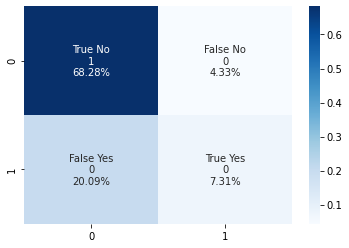

In [96]:
# model evaluation
clf_report = clf_evaluation(X_train, y_train, X_test, y_test, classification)


In [97]:
clf_report

,precision,recall,f1-score,AUC,support
No,0.773,0.940,0.848,0.775,1023.000
Yes,0.628,0.267,0.375,-,386.000
accuracy,0.756,0.756,0.756,0.756,0.756
macro avg,0.700,0.604,0.611,-,1409.000
weighted avg,0.733,0.756,0.719,-,1409.000


### 7. Handling data imbalance

In [98]:
y_train.value_counts()

Churn
No       4151
Yes      1483
dtype: int64

In [99]:
# function to deal with class imbalances in binary classification
# inputs: dfs for training set x, y, sampling method identification string, targeted ratio for maj./min. class for up-/down-/mix-sampling
# outputs: balanced training set x, y 

def class_balancing(imb_X, imb_Y, method='down', ratio=1.5): 
    # values to navigate target variable
    target_col = list(imb_Y.columns.values)[0]
    values_sorted = imb_Y[target_col].value_counts()
    train_imbalanced = pd.concat([imb_X, imb_Y], axis=1)    
    # SMOTE
    if method == 'smo':
        smote = SMOTE()
        bal_X, bal_Y = smote.fit_resample(imb_X, imb_Y) 
    #TomekLinks
    elif method == 'tl':
        undersample = TomekLinks()
        bal_X, bal_Y = undersample.fit_resample(imb_X, imb_Y)
    else:    
        # Downsampling
        if method == 'down':
            sample_size = values_sorted[1]
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(round(sample_size*ratio))
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(sample_size)
        # Upsampling    
        elif method == 'up':
            sample_size = values_sorted[0]
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(sample_size)
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(round(sample_size/ratio), replace=True)
        # Mix Up-/Downsampling
        elif method == 'mix':
            sample_size = values_sorted[1]
            imbalance_factor = math.floor(values_sorted[0]/values_sorted[1])
            sample_factor = math.floor(imbalance_factor/3)
            maj_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[0]].sample(round(sample_size*sample_factor*ratio))
            min_class = train_imbalanced[train_imbalanced[target_col] == values_sorted.index[1]].sample(round(sample_size*sample_factor), replace=True)
          
        train_sampled = pd.concat([maj_class, min_class]).sample(frac=1)
        # creating dfs of balanced classes to return
        bal_X = train_sampled.drop([target_col], axis=1)
        bal_Y = pd.DataFrame(train_sampled[target_col])
    return bal_X, bal_Y

**Model with downsampling**

In [100]:
# downsampling
X_train_ds, y_train_ds = class_balancing(X_train, y_train, method='down')

In [101]:
y_train_ds.value_counts()

Churn
No       2224
Yes      1483
dtype: int64

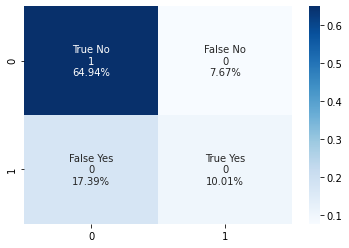

In [102]:
# Building model
classification = LogisticRegression(random_state=51, max_iter=1000) 
classification.fit(X_train_ds, y_train_ds)

# model evaluation
clf_ds_report = clf_evaluation(X_train_ds, y_train_ds, X_test, y_test, classification)

In [103]:
clf_ds_report

,precision,recall,f1-score,AUC,support
No,0.789,0.894,0.838,0.771,1023.000
Yes,0.566,0.365,0.444,-,386.000
accuracy,0.749,0.749,0.749,0.749,0.749
macro avg,0.678,0.630,0.641,-,1409.000
weighted avg,0.728,0.749,0.730,-,1409.000


**Model with upsampling**

In [104]:
# upsampling
X_train_us, y_train_us = class_balancing(X_train, y_train, method='up')

In [105]:
y_train_us.value_counts()

Churn
No       4151
Yes      2767
dtype: int64

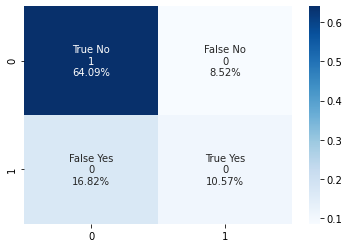

In [106]:
# Building model
classification = LogisticRegression(random_state=51, max_iter=1000) 
classification.fit(X_train_us, y_train_us)

# model evaluation
clf_us_report = clf_evaluation(X_train_us, y_train_us, X_test, y_test, classification)

In [107]:
clf_us_report

,precision,recall,f1-score,AUC,support
No,0.792,0.883,0.835,0.78,1023.000
Yes,0.554,0.386,0.455,-,386.000
accuracy,0.747,0.747,0.747,0.747,0.747
macro avg,0.673,0.634,0.645,-,1409.000
weighted avg,0.727,0.747,0.731,-,1409.000


**Model with SMOTE sampling**

In [108]:
# SOMTE sampling
X_train_smo, y_train_smo = class_balancing(X_train, y_train, method='up')

In [109]:
y_train_smo.value_counts()

Churn
No       4151
Yes      2767
dtype: int64

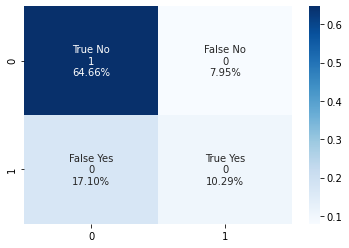

In [110]:
# Building model
classification = LogisticRegression(random_state=51, max_iter=1000) 
classification.fit(X_train_smo, y_train_smo)

# model evaluation
clf_smo_report = clf_evaluation(X_train_smo, y_train_smo, X_test, y_test, classification)

In [111]:
clf_smo_report

,precision,recall,f1-score,AUC,support
No,0.791,0.891,0.838,0.782,1023.000
Yes,0.564,0.376,0.451,-,386.000
accuracy,0.749,0.749,0.749,0.749,0.749
macro avg,0.678,0.633,0.644,-,1409.000
weighted avg,0.729,0.749,0.732,-,1409.000
